In [81]:
import json
from matplotlib import pyplot as plt
import pandas as pd
import os
import glob
import numpy as np
from empiricaldist import Cdf
import shutil

add_path = ''
base_path = '../simulator/bin/simData'
if add_path: base_path += f'/{add_path}'

metric_to_measure = ['pbusy', 'pfree', 'ptransmit', 'preset', 'pstable', 'pfailed', 'psent', 'epsilon', 'k', 't', 'interval', 'counter', 'reward']
metric_to_measure_slotframe = [*metric_to_measure, 'eb_prob', "mbr", "nbr"]

# Rank Result

In [82]:
!cd /Users/dzakyzf/lain/iotlab/simulator/bin; python3.7 compute_kpis.py --path={add_path}

generating KPIs for simData/ori_exp4_imin1_motes50_1/exec_numMotes_50.dat
generating KPIs for simData/qt_exp4_imin5_motes50_1/exec_numMotes_50.dat
generating KPIs for simData/riata_exp4_imin5_motes50_1/exec_numMotes_50.dat
generating KPIs for simData/qt_exp4_imin10_motes50_1/exec_numMotes_50.dat
generating KPIs for simData/ac_exp4_imin5_motes50_1/exec_numMotes_50.dat
KPIs saved in simData/riata_exp4_imin5_motes50_1/exec_numMotes_50.dat.json
KPIs saved in simData/ac_exp4_imin5_motes50_1/exec_numMotes_50.dat.json
KPIs saved in simData/qt_exp4_imin5_motes50_1/exec_numMotes_50.dat.json
KPIs saved in simData/ori_exp4_imin1_motes50_1/exec_numMotes_50.dat.json
KPIs saved in simData/qt_exp4_imin10_motes50_1/exec_numMotes_50.dat.json
generating KPIs for simData/ac_exp4_imin10_motes50_1/exec_numMotes_50.dat
generating KPIs for simData/ori_exp4_imin5_motes50_1/exec_numMotes_50.dat
generating KPIs for simData/qt_exp4_imin1_motes50_1/exec_numMotes_50.dat
generating KPIs for simData/riata_exp4_imin1

In [91]:
import pandas as pd

pd.set_option('display.max_colwidth', None)

df = pd.read_csv(f'{base_path}/comparison_merged.csv', sep='\t')
df = df[df.columns[~df.columns.str.contains('-std|dead')]]
# df['combined'] = (
#     (1-(df['trickle_psent-mean-mean'] / df['trickle_psent-mean-mean'].max())) +
#     (df['rpljoin_time_m-mean-mean'] / df['rpljoin_time_m-mean-mean'].max()) +
#     (df['current-consumed-mean-mean'] / df['current-consumed-mean-mean'].max())
# ) / 3
df.sort_values(by=['rpljoin_time_m-mean-mean'], inplace=True, ignore_index=True, ascending=True)
df.style.highlight_min(color = 'blue', axis = 0).highlight_max(color = 'green', axis = 0)

,method,trickle_reward-mean-mean,rpljoin_time_m-mean-mean,current-consumed-mean-mean,last_pfailed--mean,last_psent--mean,trickle_pbusy-mean-mean,last_failed_dio-sum-mean,last_count_dio-sum-mean,alive_nodes-mean,ori_name,parameter
0,QT,0.784942,5.188407,0.059614,0.024541,0.975459,0.368349,2.333333,89.666667,9.000000,qt_exp4_imin10_motes10_1,"(10, 10)"
1,AC,0.000000,5.364846,0.052894,0.046336,0.953664,0.498972,4.666667,101.000000,9.000000,ac_exp4_imin10_motes10_1,"(10, 10)"
2,QT,0.763255,5.498889,0.053348,0.032184,0.967816,0.457693,6.333333,201.333333,9.000000,qt_exp4_imin1_motes10_1,"(10, 1)"
3,QT,0.803308,5.616722,0.058544,0.023336,0.976664,0.413564,2.666667,114.000000,9.000000,qt_exp4_imin5_motes10_1,"(10, 5)"
4,RIATA,0.245503,5.743284,0.056904,0.043054,0.956946,0.480616,5.333333,122.000000,9.000000,riata_exp4_imin5_motes10_1,"(10, 5)"
5,RIATA,0.271810,5.766975,0.058123,0.040075,0.959925,0.434875,4.000000,99.666667,9.000000,riata_exp4_imin10_motes10_1,"(10, 10)"
6,ORI,0.000000,5.824957,0.052888,0.058707,0.941293,0.494259,6.000000,105.333333,9.000000,ori_exp4_imin10_motes10_1,"(10, 10)"
7,ORI,0.000000,5.921593,0.059060,0.037169,0.962831,0.548279,5.000000,144.000000,9.000000,ori_exp4_imin5_motes10_1,"(10, 5)"
8,AC,0.000000,6.006383,0.056737,0.052207,0.947793,0.492594,6.333333,121.000000,9.000000,ac_exp4_imin5_motes10_1,"(10, 5)"
9,ORI,0.000000,6.363000,0.058475,0.032733,0.967267,0.550776,7.666667,237.666667,9.000000,ori_exp4_imin1_motes10_1,"(10, 1)"


In [84]:
# test = df[df['parameter'].str.startswith('(100, 10)')]
# test.style.highlight_min(color = 'blue', axis = 0).highlight_max(color = 'green', axis = 0)

# Convergence

In [85]:
# define the name of the directory to be deleted
fig_path = f"{base_path}/figures"

def remove_create_folder(path):
    try:
        shutil.rmtree(path)
    except OSError as e:
        pass

    try:
        os.makedirs(path)
    except OSError as e:
        pass

remove_create_folder(fig_path)

In [86]:
subfolders = list(
    [os.path.join(base_path, x) for x in os.listdir(base_path)]
)

main_result = {}

for subfolder in subfolders:
    if not os.path.isdir(subfolder):
        continue
    
    mthd = subfolder.split('/')[-1]
    for infile in glob.glob(os.path.join(subfolder, '*.dat.json')):
        with open(infile, 'r') as f:
            data = json.load(f)

            result = {}
            for k in metric_to_measure:
                new_key = f'trickle_{k}'
                result[new_key] = {}

            for k in metric_to_measure_slotframe:
                new_key = f'slotframe_{k}'
                result[new_key] = {}

            per_slotframe_run = 0
            for run_id in data.keys():
                for mote_id in data[run_id].keys():
                    if mote_id == 'global-stats':
                        per_slotframe_run = data[run_id]['global-stats']['per_slotframe_run'] 
                        result['per_slotframe_run'] = per_slotframe_run
                        continue
                
                    for it in data[run_id][mote_id]['trickle']:
                        trickle_it = int(it)
                        trickle_data = data[run_id][mote_id]['trickle'][it]

                        for k in metric_to_measure:
                            new_key = f'trickle_{k}'
                            if trickle_it not in result[new_key].keys():
                                result[new_key][trickle_it] = []
                            
                            if k in trickle_data.keys():
                                new_key = f'trickle_{k}'
                                val = trickle_data[k]
                                if val is not None:
                                    result[new_key][trickle_it].append(val)

                    for k in metric_to_measure_slotframe:
                        new_key = f'slotframe_{k}'
                        values = data[run_id][mote_id].get(f'per_slotframe_{k}', [])

                        for idx, val in enumerate(values):
                            if idx not in result[new_key].keys():
                                result[new_key][idx] = []
                            result[new_key][idx].append(val)
            algo = infile.split("/")[-2]
            main_result[algo] = result

### Figure per algorithm

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

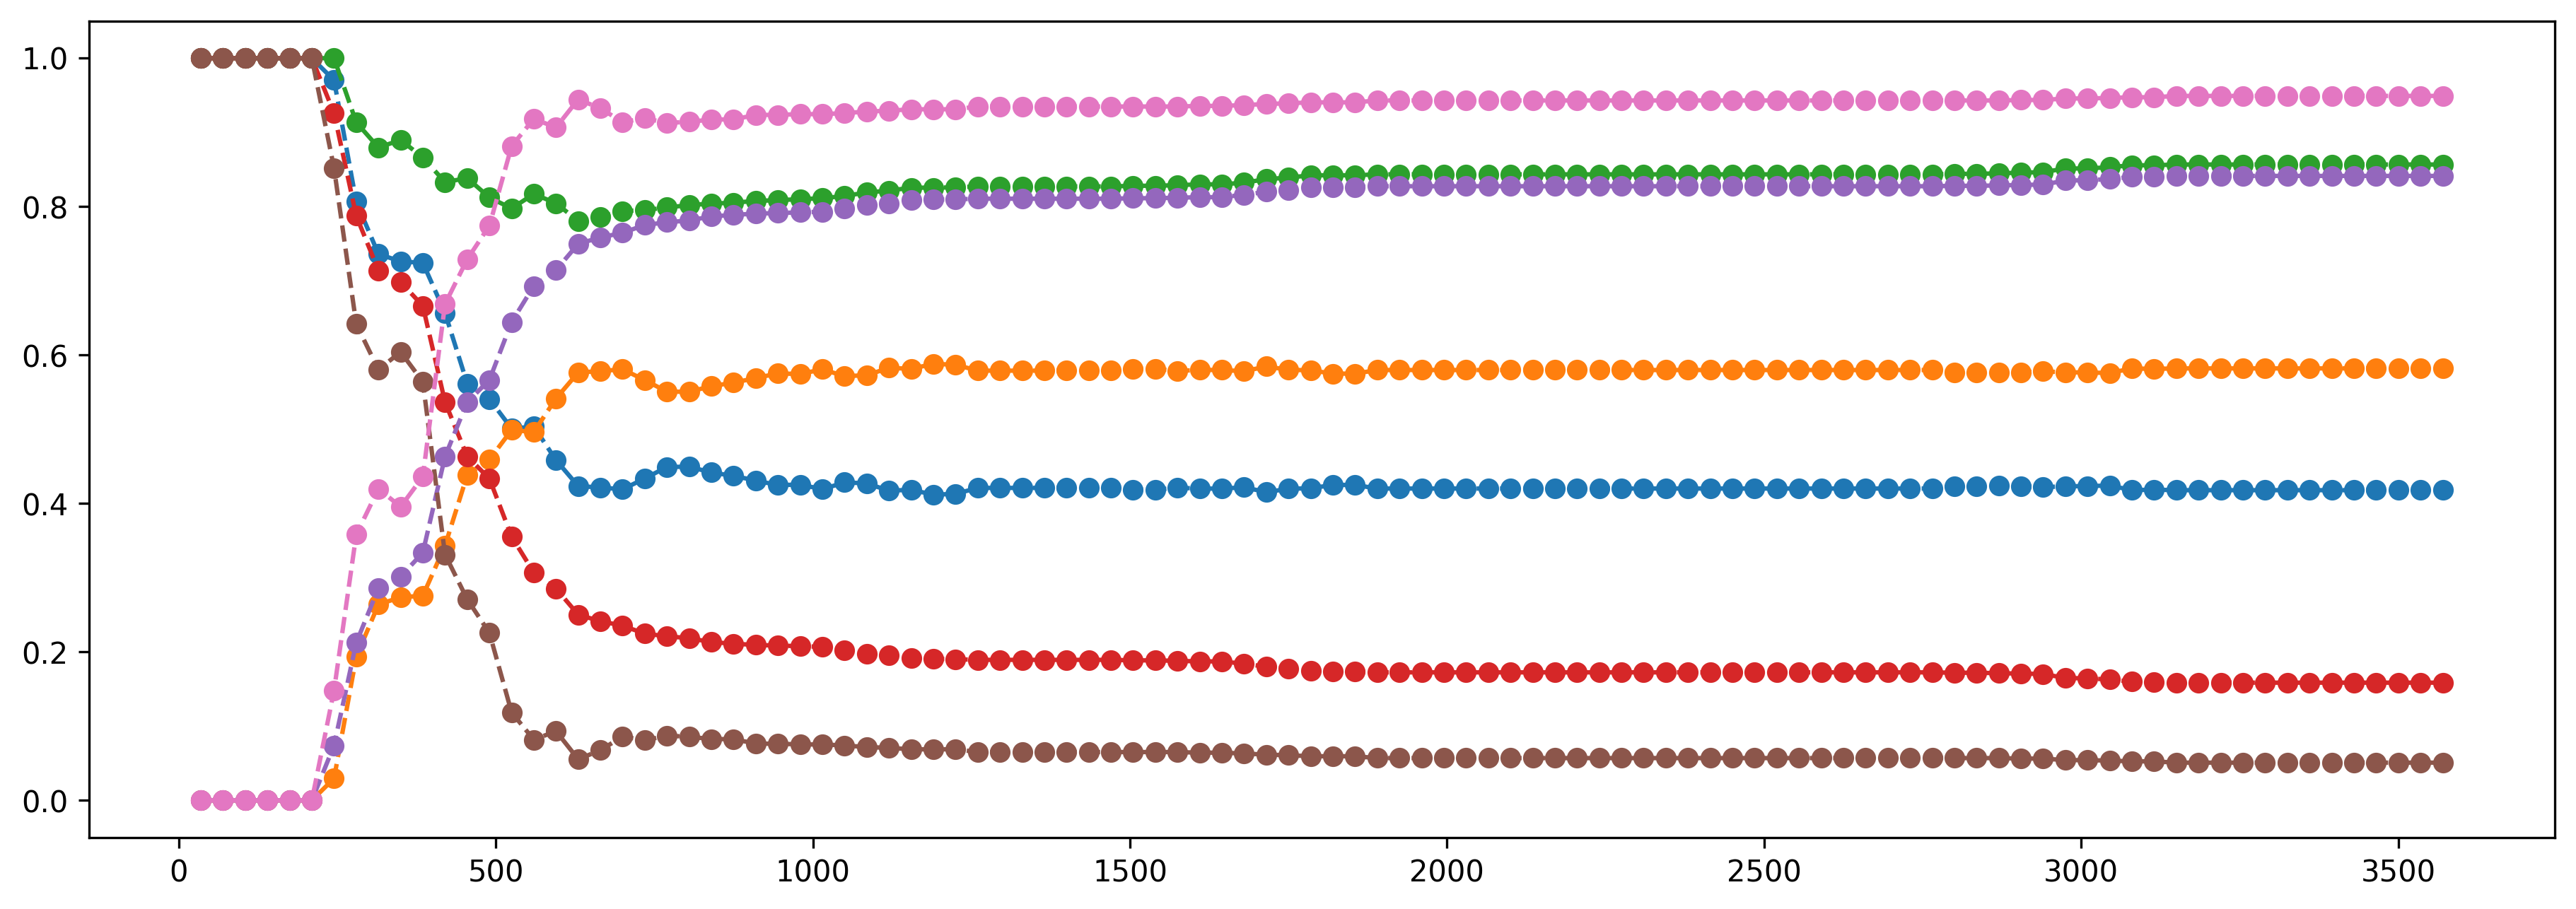

In [87]:
conv_base_path = f'{fig_path}/Figure per algorithm/'
remove_create_folder(conv_base_path)

# Trickle states
for algo in sorted(main_result.keys()):
    fig = plt.figure(figsize=(15,5), dpi=300)
    
    for k in metric_to_measure:
        metric = f'trickle_{k}'

        data = []
        is_over = False
        for state in sorted(main_result[algo][metric].keys()):
            values = main_result[algo][metric][state]
            if not values or all(i is None for i in values): continue
            mean_ = np.mean(values)
            if np.max(values) > 1: is_over = True
            data.append(mean_)
        
        if not is_over: plt.plot(data, label=metric, linestyle='--', marker='o')
        
    plt.legend()
    plt.title(f'Trickle of {algo}')
    plt.xlabel('Trickle states')
    plt.ylabel('Values')
    plt.tight_layout()
    plt.savefig(f"{conv_base_path}/Trickle_{algo}.png")
    plt.close()

# Per slotframe
for algo in sorted(main_result.keys()):
    fig = plt.figure(figsize=(15,5), dpi=300)
    per_slotframe_run = main_result[algo]['per_slotframe_run']
    
    for k in metric_to_measure_slotframe:
        metric = f'slotframe_{k}'

        data = []
        is_over = False
        for slotframe in sorted(main_result[algo][metric].keys()):
            values = main_result[algo][metric][slotframe]
            if not values or all(i is None for i in values): continue
            mean_ = np.mean(values)
            if np.max(values) > 1: is_over = True
            data.append(mean_)
        
        if not is_over:
            range_ = [x*per_slotframe_run for x in range(1, len(data)+1)]
            plt.plot(range_, data, label=metric, linestyle='--', marker='o')
    
    plt.legend()
    plt.title(f'Slotframe of {algo}')
    plt.xlabel('Slotframe')
    plt.ylabel('Values')
    plt.tight_layout()
    plt.savefig(f"{conv_base_path}/Slotframe_{algo}.png")
    plt.close()

### Figure per metric

In [ ]:
conv_base_path = f'{fig_path}/Figure per metric/'
remove_create_folder(conv_base_path)

# Trickle states
for k in metric_to_measure:
    fig = plt.figure(figsize=(15,5), dpi=300)
    metric = f'trickle_{k}'

    for algo in sorted(main_result.keys()):

        data = []
        for state in sorted(main_result[algo][metric].keys()):
            values = main_result[algo][metric][state]
            if not values or all(i is None for i in values): continue
            mean_ = np.mean(values)
            data.append(mean_)
        
        plt.plot(data, label=f'{metric}_{algo}', linestyle='--', marker='o')
        
    plt.legend()
    plt.title(f'Trickle of {metric}')
    plt.xlabel('Trickle states')
    plt.ylabel('Values')
    plt.tight_layout()
    plt.savefig(f"{conv_base_path}/metric_{metric}.png")
    plt.close()

# Per slotframe
for k in metric_to_measure_slotframe:
    fig = plt.figure(figsize=(15,5), dpi=300)
    metric = f'slotframe_{k}'
    
    for algo in sorted(main_result.keys()):
        data = []
        per_slotframe_run = main_result[algo]['per_slotframe_run']
        for slotframe in sorted(main_result[algo][metric].keys()):
            values = main_result[algo][metric][slotframe]
            if not values or all(i is None for i in values): continue
            mean_ = np.mean(values)
            data.append(mean_)
        
        range_ = [x*per_slotframe_run for x in range(1, len(data)+1)]
        plt.plot(range_, data, label=f'{metric}_{algo}', linestyle='--', marker='o')
    
    plt.legend()
    plt.title(f'Slotframe of {metric}')
    plt.xlabel('Slotframe')
    plt.ylabel('Values')
    plt.tight_layout()
    plt.savefig(f"{conv_base_path}/metric_{metric}.png")
    plt.close()

In [ ]:
# algo = 'ori_5_exp3_random3_runs1_motes10_minutes60_disprio1_autoeb3_autok1_autot1_ql1'
# metric = 'slotframe_nbr'


# data = []
# for slotframe in sorted(main_result[algo][metric].keys()):
#     values = main_result[algo][metric][slotframe]
#     mean_ = int(np.ceil(np.mean(values)))
#     data.append(mean_)

In [ ]:
# algo = 'ori_2_exp3_random3_runs1_motes10_minutes60_disprio1_autoeb3_autok1_autot1_ql1'
# metric = 'trickle_pbusy'

# data = []
# for state in sorted(main_result[algo][metric].keys()):
#     values = main_result[algo][metric][state]
#     mean_ = np.mean(values)
#     data.append(mean_)

In [ ]:
# temp = np.array(data) + data[-1]
# aa = np.ceil(np.arange(5, 2, -0.1))
# data2 = [*data, *aa, *temp]
# # 
# eb_prob = 1/4
# max_ = 1 - eb_prob

In [ ]:
# total = 0
# avgs = []
# avg = 0
# prev_val = None
# move = []
# move2 = []

# for idx, val in enumerate(data2):
#     total += val
#     avg = total / (idx+1)
#     avgs.append(avg)

#     m = 1
#     move.append(m)
#     eb_used_prob = eb_prob
#     eb_used_prob += (max_ / pow(2, val))
    
#     move2.append(eb_used_prob)
#     prev_val = val

# plt.plot(move2)
# plt.plot(len(move2) * [eb_prob])
# plt.show()
# plt.close()

In [ ]:
# plt.plot(data2)
# plt.plot(avgs)
# plt.plot(move)
# plt.show()
# plt.close()

### CDF all algorithms

In [ ]:
conv_base_path = f'{fig_path}/CDF all algorithms'
remove_create_folder(conv_base_path)

# Trickle states
for k in metric_to_measure:
    fig = plt.figure(figsize=(10,10), dpi=300)
    metric = f'trickle_{k}'

    for algo in sorted(main_result.keys()):
        data = []
        for state in sorted(main_result[algo][metric].keys()):
            values = main_result[algo][metric][state]
            if not values or all(i is None for i in values): continue
            mean_ = np.mean(values)
            data.append(mean_)
        
        if len(data) > 0: Cdf.from_seq(data).plot()
        
    plt.legend(main_result.keys())
    plt.title(metric)
    plt.xlabel('Values')
    plt.ylabel('CDF')
    plt.tight_layout()
    plt.savefig(f"{conv_base_path}/{metric}_cdf.png")
    plt.close()


# Per slotframe
for k in metric_to_measure_slotframe:
    fig = plt.figure(figsize=(10,10), dpi=300)
    metric = f'slotframe_{k}'
    
    for algo in sorted(main_result.keys()):
        data = []
        per_slotframe_run = main_result[algo]['per_slotframe_run']
        for slotframe in sorted(main_result[algo][metric].keys()):
            values = main_result[algo][metric][slotframe]
            if not values or all(i is None for i in values): continue
            mean_ = np.mean(values)
            data.append(mean_)
        
        if len(data) > 0: Cdf.from_seq(data).plot()
    
    plt.legend(main_result.keys())
    plt.title(metric)
    plt.xlabel('Values')
    plt.ylabel('CDF')
    plt.tight_layout()
    plt.savefig(f"{conv_base_path}/{metric}_cdf.png")
    plt.close()